In [1]:
from sklearn import datasets, cross_validation, linear_model, grid_search
import numpy as np
import pandas as pd
import operator


import matplotlib.pyplot as plt

from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor as rfr


from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.grid_search import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('movie_data_13527_fixed_binaries_inflation_adjusted.csv')

df['total_gross'] = df['International Gross (2016 dollars)'] + df['Domestic Gross (2016 dollars)']
df['Domestic_Gross/Budget'] = df['Domestic Gross (2016 dollars)']/df['Budget (2016 dollars)']
df['International_Gross/Budget'] = df['International Gross (2016 dollars)']/df['Budget (2016 dollars)']
df['Total_Gross/Budget'] = df['Domestic_Gross/Budget'] + df['International_Gross/Budget']


# dropping things not used in the model
todrop = ['Rank', 'Movie Title', 'Theaters', 'Theaters.1', 'Genre', 'Studio', 'Close', 'Link', 'All Time Worldwide', 'All Time Domestic', 'Worldwide Yearly', 'Worldwide Yearly in Rating']
for entry in todrop:
    df.drop(entry, axis = 1, inplace = True)
    
# Parsing opening date into an ordinal day of year and defining whether it's summer    
def dayofyear(datestr):
    try:
        datelist = datestr.split('/')
        m, d = int(datelist[0]), int(datelist[1])
        days = [31,29,31,30,31,30,31,31,30,31,30,31]
        return sum(days[:m-1]) + d
    except ValueError:
        return np.NaN

def month(datestr):
    try:
        datelist = datestr.split('/')
        return int(datelist[0])
    except ValueError:
        return np.NaN

def summer(datestr):
    try:
        datelist = datestr.split('/')
        return int(int(datelist[0]) in [6,7,8])
    except ValueError:
        return np.NaN
    
df['summer'] = df['Open'].apply(summer)
df['month'] = df['Open'].apply(month)
df.Open = df.Open.apply(dayofyear)

In [3]:
# A Dictionary of what pecernt of figures in each column are NaNs
nanpct = {}
for column in df.columns:
    colcopy = df[column].copy()
    colcopy.dropna(axis = 0, inplace = True)
    nanpct[column] = (len(df[column]) - len(colcopy))/len(df[column]) * 100
framecopy = df.copy()
framecopy.dropna(axis = 0, inplace = True)
nanpct['any_column'] = (len(df) - len(framecopy))/len(df)
sorted(nanpct.items(), key=operator.itemgetter(1), reverse = True)

[('International_Gross/Budget', 82.9365666124501),
 ('Total_Gross/Budget', 82.9365666124501),
 ('Budget (2016 dollars)', 78.70767410912318),
 ('Domestic_Gross/Budget', 78.70767410912318),
 ('International Gross (2016 dollars)', 62.61274582285967),
 ('total_gross', 62.61274582285967),
 ('Opening', 6.98654443294396),
 ('any_column', 0.8296613928729853),
 ('Runtime', 0.6358125092414609),
 ('Open', 0.2809404110601804),
 ('summer', 0.2809404110601804),
 ('month', 0.2809404110601804),
 ('comedy', 0.0),
 ('epic', 0.0),
 ('family', 0.0),
 ('crime', 0.0),
 ('animation', 0.0),
 ('concert', 0.0),
 ('thriller', 0.0),
 ('music', 0.0),
 ('foreign', 0.0),
 ('romance', 0.0),
 ('documentary', 0.0),
 ('scifi', 0.0),
 ('war', 0.0),
 ('Domestic Gross (2016 dollars)', 0.0),
 ('period', 0.0),
 ('Year', 0.0),
 ('Rating', 0.0),
 ('western', 0.0),
 ('romantic', 0.0),
 ('imax', 0.0),
 ('sports', 0.0),
 ('action', 0.0),
 ('historical', 0.0),
 ('fantasy', 0.0),
 ('horror', 0.0),
 ('musical', 0.0),
 ('adventure', 

Most of the data gaps are in budget and return, so there's not much you can do to fill them.

In [4]:
# dropping NaNs
features = df.copy()
features.dropna(axis = 0, inplace = True)

In [5]:
features.columns

Index(['Domestic Gross (2016 dollars)', 'Opening', 'Open', 'Year',
       'International Gross (2016 dollars)', 'Budget (2016 dollars)',
       'Runtime', 'Rating', 'action', 'romantic', 'musical', 'concert', 'imax',
       'comedy', 'war', 'fantasy', 'historical', 'period', 'drama', 'thriller',
       'adventure', 'western', 'horror', 'romance', 'animation', 'scifi',
       'music', 'crime', 'foreign', 'sports', 'family', 'documentary', 'epic',
       'total_gross', 'Domestic_Gross/Budget', 'International_Gross/Budget',
       'Total_Gross/Budget', 'summer', 'month'],
      dtype='object')

In [6]:
genre_names = ['action', 'romantic', 'musical', 'concert', 'imax',
       'comedy', 'war', 'fantasy', 'historical', 'period', 'drama', 'thriller',
       'adventure', 'western', 'horror', 'romance', 'animation', 'scifi',
       'music', 'crime', 'foreign', 'sports', 'family', 'documentary', 'epic']

pctfull = {}
for name in genre_names:
    pctfull[name] = features[name].sum()/len(features)*100
sorted(pctfull.items(), key=operator.itemgetter(1), reverse = True)

[('comedy', 31.553819444444443),
 ('drama', 21.354166666666664),
 ('action', 16.927083333333336),
 ('thriller', 12.022569444444445),
 ('horror', 9.98263888888889),
 ('adventure', 7.942708333333333),
 ('scifi', 6.597222222222222),
 ('animation', 6.206597222222222),
 ('romantic', 5.295138888888888),
 ('family', 4.817708333333334),
 ('crime', 4.296875),
 ('period', 3.689236111111111),
 ('fantasy', 3.4288194444444446),
 ('sports', 2.430555555555556),
 ('romance', 2.34375),
 ('war', 1.6059027777777777),
 ('foreign', 1.3888888888888888),
 ('music', 1.2586805555555556),
 ('western', 0.8246527777777778),
 ('historical', 0.8246527777777778),
 ('musical', 0.78125),
 ('documentary', 0.607638888888889),
 ('epic', 0.2170138888888889),
 ('concert', 0.08680555555555555),
 ('imax', 0.043402777777777776)]

In [7]:
# Dropping columns below 1%, everything that ticks at least one box there is "some other genre"
others = np.zeros(features.Year.shape)
for name in genre_names:
    if pctfull[name] < 1:
        others = others + features[name]
        features.drop(name, axis = 1, inplace = True)
features['other_genre'] = ((others > 0) + 0)

In [8]:
features['total_genres'] = np.zeros(features.Year.shape)
for name in genre_names:
    if name in features.columns:
        features['total_genres'] = features['total_genres'] + features[name]
features['total_genres'] = features['total_genres'] + features['other_genre']

Next we need to remove outliers in terms of gross/budget to avoid skewing our data set.

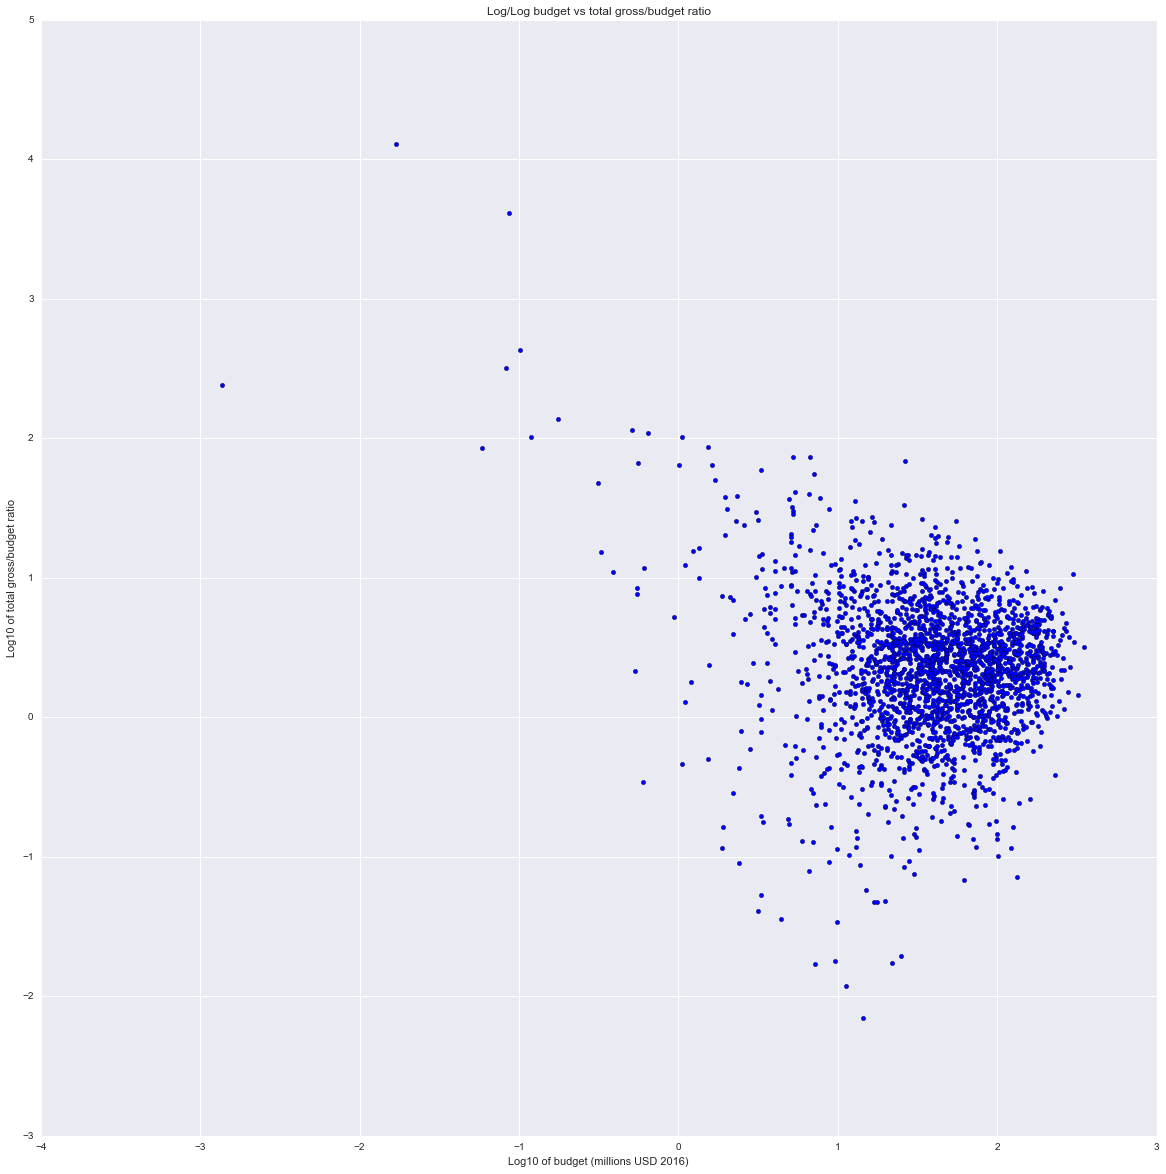

In [9]:
plt.figure(figsize = [20,20])
plt.scatter(np.log10(features['Budget (2016 dollars)']/10**6), np.log10(features['Total_Gross/Budget']))
# plt.scatter(np.log10(features['Budget (2016 dollars)']/10**6), np.log10(features['total_gross']/10**6))

plt.title('Log/Log budget vs total gross/budget ratio')
plt.xlabel('Log10 of budget (millions USD 2016)')
plt.ylabel('Log10 of total gross/budget ratio')

The low budget movies almost all have a high gross/budget ratio because its an unrepresentative set. Most $50,000 budget films don't get released at all; the ones in our data set are the few lucky/good ones. 

I'll set a threshold at 10 million by eye

In [10]:
len(features)

2304

In [11]:
features = features[features['Budget (2016 dollars)'] > 10**7]
len(features)

2085

In [12]:
df.columns

Index(['Domestic Gross (2016 dollars)', 'Opening', 'Open', 'Year',
       'International Gross (2016 dollars)', 'Budget (2016 dollars)',
       'Runtime', 'Rating', 'action', 'romantic', 'musical', 'concert', 'imax',
       'comedy', 'war', 'fantasy', 'historical', 'period', 'drama', 'thriller',
       'adventure', 'western', 'horror', 'romance', 'animation', 'scifi',
       'music', 'crime', 'foreign', 'sports', 'family', 'documentary', 'epic',
       'total_gross', 'Domestic_Gross/Budget', 'International_Gross/Budget',
       'Total_Gross/Budget', 'summer', 'month'],
      dtype='object')

Next I look at the budget and mean gross.

In [13]:
ratingdict = {0:'G',1:'PG',2:'PG-13',3: 'R', 4: 'NC-17', 5: 'Unrated',6: 'X'}
def ratingtrans(value):
    return ratingdict[value]

In [14]:
byrating = features.groupby("Rating", as_index=False).mean()[['Budget (2016 dollars)', 'Domestic Gross (2016 dollars)', 'International Gross (2016 dollars)']]
byrating['Rating'] = byrating.index
byrating.Rating = byrating.Rating.apply(ratingtrans)
byrating['mean_Domestic_Gross/Budget'] = byrating['Domestic Gross (2016 dollars)']/byrating['Budget (2016 dollars)']
byrating['mean_International_Gross/Budget'] = byrating['International Gross (2016 dollars)']/byrating['Budget (2016 dollars)']
byrating['mean_Total_Gross/Budget'] = byrating['mean_International_Gross/Budget'] + byrating['mean_Domestic_Gross/Budget']
byrating['budget_means_mil'] = byrating['Budget (2016 dollars)']/10**6
byrating['international_means_mil'] = byrating['International Gross (2016 dollars)']/10**6
byrating['domestic_means_mil'] = byrating['Domestic Gross (2016 dollars)']/10**6
byrating.dropna(axis = 0, inplace = True)

num_films = []
for i in range(6):  
    num_films.append(sum(features.Rating == i))
byrating['num_films'] = num_films

byrating[['Rating','num_films','mean_Domestic_Gross/Budget','mean_International_Gross/Budget', 'mean_Total_Gross/Budget']]

,Rating,num_films,mean_Domestic_Gross/Budget,mean_International_Gross/Budget,mean_Total_Gross/Budget
0,G,61,1.638682,2.088505,3.727187
1,PG,334,1.503856,1.816522,3.320378
2,PG-13,898,1.363994,1.694236,3.058230
3,R,783,1.254098,1.402151,2.656250
4,NC-17,2,0.234841,2.428720,2.663561
5,Unrated,7,0.063921,2.343547,2.407468


I would hesitate to draw conclusions from the NC-17 and Unrated statistics, as there are very few films in either category. Aside from small sample size, this also implies that the sample is likely skewed; that the NC-17 and Unrated films which survive in our set are very unrepresentative. I therefore leave them out of the next two plots.

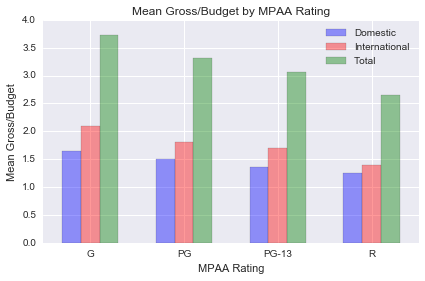

In [15]:
fig, ax = plt.subplots()#figsize = [10,10]

bar_width = 0.20
right_shift = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(byrating.index[:4] + right_shift, byrating['mean_Domestic_Gross/Budget'][:4], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Domestic')

rects2 = plt.bar(byrating.index[:4] + right_shift + bar_width, byrating['mean_International_Gross/Budget'][:4], bar_width,
                 alpha=opacity,
                 color='r',
                 label='International')

rects3 = plt.bar(byrating.index[:4] + right_shift + 2 * bar_width, byrating['mean_Total_Gross/Budget'][:4], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Total')

plt.xlabel('MPAA Rating')
plt.ylabel('Mean Gross/Budget')
plt.title('Mean Gross/Budget by MPAA Rating')
plt.xticks(byrating.index[:4] + 0.5, byrating.Rating[:4])
# plt.font()
plt.legend()

plt.tight_layout()
plt.show()




Among the major ratings, we have enough films to tease out a relationship. For both foreign and domestic films, more restrictive ratings mean a lower total gross to budget ratio, though this declines more rapidly with rating restrictiveness in the international market. This is most likely due to higher rated films being rejected or marginalized in media markets more restrictive/puritanical than the US (Mainland China, the Gulf States, etc.)

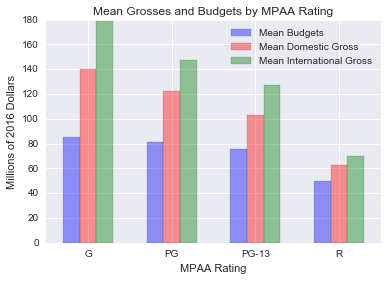

In [16]:

fig, ax = plt.subplots()#figsize = [10,10]

bar_width = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(byrating.index[:4] + bar_width, byrating['budget_means_mil'][:4], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Mean Budgets')

rects2 = plt.bar(byrating.index[:4] + 2 * bar_width, byrating['domestic_means_mil'][:4], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Mean Domestic Gross')

rects3 = plt.bar(byrating.index[:4] + 3 * bar_width, byrating['international_means_mil'][:4], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Mean International Gross')


plt.xlabel('MPAA Rating')
plt.ylabel('Millions of 2016 Dollars')
plt.title('Mean Grosses and Budgets by MPAA Rating')
plt.xticks(byrating.index[:4] + 0.5, byrating.Rating[:4])
plt.legend(loc = 'best')

# bymonth


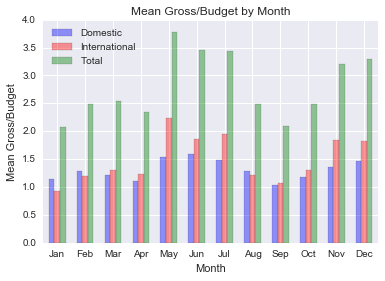

In [17]:
monthlist = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

bymonth = features.groupby("month", as_index=False).mean()[['Budget (2016 dollars)', 'Domestic Gross (2016 dollars)', 'International Gross (2016 dollars)']]
bymonth['month'] = bymonth.index + 1
# # byrating.Rating = byrating.Rating.apply(ratingtrans)
bymonth['budget_means_mil'] = bymonth['Budget (2016 dollars)']/10**6
bymonth['international_means_mil'] = bymonth['International Gross (2016 dollars)']/10**6
bymonth['domestic_means_mil'] = bymonth['Domestic Gross (2016 dollars)']/10**6

bymonth['mean_Domestic_Gross/Budget'] = bymonth['Domestic Gross (2016 dollars)']/bymonth['Budget (2016 dollars)']
bymonth['mean_International_Gross/Budget'] = bymonth['International Gross (2016 dollars)']/bymonth['Budget (2016 dollars)']
bymonth['mean_Total_Gross/Budget'] = bymonth['mean_International_Gross/Budget'] + bymonth['mean_Domestic_Gross/Budget']
# bymonth = bymonth[['budget_means_mil','international_means_mil', 'domestic_means_mil', 'month']]
bymonth.dropna(axis = 0, inplace = True)

fig, ax = plt.subplots()#figsize = [8,8]

bar_width = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(bymonth.month - min(bymonth.month) + bar_width, bymonth['mean_Domestic_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Domestic')

rects2 = plt.bar(bymonth.month - min(bymonth.month) + 2 * bar_width, bymonth['mean_International_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='International')

rects3 = plt.bar(bymonth.month - min(bymonth.month) + 3 * bar_width, bymonth['mean_Total_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Total')

plt.xlabel('Month')
plt.ylabel('Mean Gross/Budget')
plt.title('Mean Gross/Budget by Month')
plt.xticks(bymonth.month - min(bymonth.month) + 0.5 , monthlist)
# plt.xlim([0,17])
plt.legend(loc = 'best')


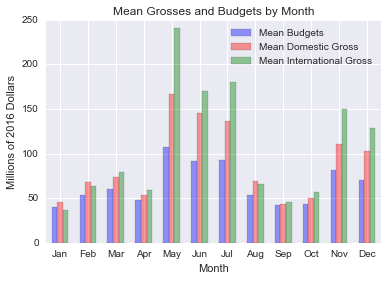

In [18]:
fig, ax = plt.subplots()#figsize = [8,8]

bar_width = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(bymonth.month - min(bymonth.month) + bar_width, bymonth['budget_means_mil'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Mean Budgets')

rects2 = plt.bar(bymonth.month - min(bymonth.month) + 2 * bar_width, bymonth['domestic_means_mil'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Mean Domestic Gross')

rects3 = plt.bar(bymonth.month - min(bymonth.month) + 3 * bar_width, bymonth['international_means_mil'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Mean International Gross')

plt.xlabel('Month')
plt.ylabel('Millions of 2016 Dollars')
plt.title('Mean Grosses and Budgets by Month')
plt.xticks(bymonth.month - min(bymonth.month) + 0.5, monthlist)
# plt.xlim([0,17])
plt.legend(loc = 'best')


In [19]:
features.Year.value_counts()

2010    146
2000    132
2002    128
2004    124
2011    122
2001    120
2003    119
2008    118
2009    113
2005    113
2006    108
2013    105
2015     98
2012     95
2014     94
2007     85
1999     82
1998     34
1997     28
1996     20
1994     19
1995     14
1991     13
1992     13
1990     12
1993     10
1988      5
1989      3
1984      3
1987      2
1982      2
1986      1
1985      1
1983      1
1981      1
1980      1
Name: Year, dtype: int64

To plot by year I only want years with enough movies with full data to be significant; if too few films are in the data set for each year this reduces significance of the average, and also means the data set is biased. For example the only film from 1980 with an international gross is the Empire Strikes Back -- the top grossing film of the year and a very unrepresentative sample of the films from that year.

I therefore only plot the years with more than 50 films, both because this is a nice discontinuity in the data, and because all the years with > 50 films are sequential.

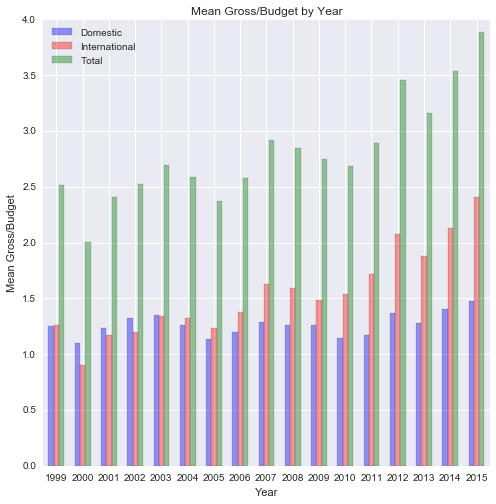

In [20]:
years, domestic_means, international_means, budget_means = [], [], [], []
for year in features.Year.unique():
    yearfeats = features[features.Year == year]
    if len(yearfeats) > 50:
        years.append(year)
        domestic_means.append(yearfeats['Domestic Gross (2016 dollars)'].mean())
        international_means.append(yearfeats['International Gross (2016 dollars)'].mean())
        budget_means.append(yearfeats['Budget (2016 dollars)'].mean())
byyear = pd.DataFrame(data = years, columns = ['year'])
byyear['budget_means_mil'] = budget_means
byyear['budget_means_mil'] = byyear['budget_means_mil']/10**6
byyear['domestic_means_mil'] = domestic_means
byyear['domestic_means_mil'] = byyear['domestic_means_mil']/10**6
byyear['international_means_mil'] = international_means
byyear['international_means_mil'] = byyear['international_means_mil']/10**6
byyear['mean_Domestic_Gross/Budget'] = byyear['domestic_means_mil']/byyear['budget_means_mil']
byyear['mean_International_Gross/Budget'] = byyear['international_means_mil']/byyear['budget_means_mil']
byyear['mean_Total_Gross/Budget'] = byyear['mean_International_Gross/Budget'] + byyear['mean_Domestic_Gross/Budget']

fig, ax = plt.subplots(figsize = [8,8])

bar_width = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}


rects1 = plt.bar(byyear.year - min(byyear.year) + bar_width, byyear['mean_Domestic_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Domestic')

rects2 = plt.bar(byyear.year - min(byyear.year) + 2 * bar_width, byyear['mean_International_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='International')

rects3 = plt.bar(byyear.year - min(byyear.year) + 3 * bar_width, byyear['mean_Total_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Total')

plt.xlabel('Year')
plt.ylabel('Mean Gross/Budget')
plt.title('Mean Gross/Budget by Year')
plt.xticks(byyear.year - min(byyear.year) + 0.5, byyear.year)
plt.xlim([0,17])
plt.legend(loc = 'best')

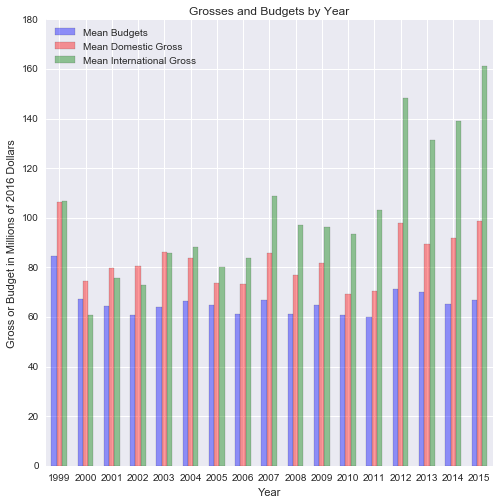

In [21]:
fig, ax = plt.subplots(figsize = [8,8])

bar_width = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(byyear.year - min(byyear.year) + bar_width, byyear['budget_means_mil'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Mean Budgets')

rects2 = plt.bar(byyear.year - min(byyear.year) + 2 * bar_width, byyear['domestic_means_mil'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Mean Domestic Gross')

rects3 = plt.bar(byyear.year - min(byyear.year) + 3 * bar_width, byyear['international_means_mil'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Mean International Gross')

plt.xlabel('Year')
plt.ylabel('Gross or Budget in Millions of 2016 Dollars')
plt.title('Grosses and Budgets by Year')
plt.xticks(byyear.year - min(byyear.year) + 0.5, byyear.year)
plt.xlim([0,17])
plt.legend(loc = 'best')

Overall, there's no clear trend in the (inflation adjusted) budget or domestic returns, however international returns are clearly rising both in absolute terms and in market share, and this is making films more profitable overall.

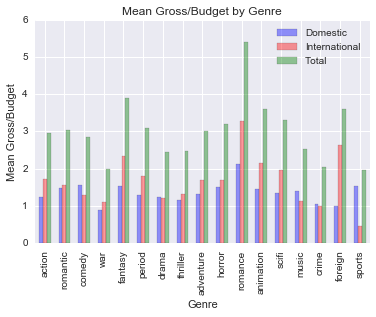

In [22]:
genres_good, domestic_means, international_means, budget_means = [], [], [], []
for genre in genre_names:
    if genre in features.columns:
        genres_good.append(genre)
        genredata = features[features[genre] > 0]
        domestic_means.append(genredata['Domestic Gross (2016 dollars)'].mean())
        international_means.append(genredata['International Gross (2016 dollars)'].mean())
        budget_means.append(genredata['Budget (2016 dollars)'].mean())
        
bygenre = pd.DataFrame(data = genres_good, columns = ['genre'])
bygenre['budget_means_mil'] = budget_means
bygenre['budget_means_mil'] = bygenre['budget_means_mil']/10**6
bygenre['domestic_means_mil'] = domestic_means
bygenre['domestic_means_mil'] = bygenre['domestic_means_mil']/10**6
bygenre['international_means_mil'] = international_means
bygenre['international_means_mil'] = bygenre['international_means_mil']/10**6
bygenre['mean_Domestic_Gross/Budget'] = bygenre['domestic_means_mil']/bygenre['budget_means_mil']
bygenre['mean_International_Gross/Budget'] = bygenre['international_means_mil']/bygenre['budget_means_mil']
bygenre['mean_Total_Gross/Budget'] = bygenre['mean_International_Gross/Budget'] + bygenre['mean_Domestic_Gross/Budget']

fig, ax = plt.subplots()#figsize = [8,8]

bar_width = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}


rects1 = plt.bar(np.arange(len(genres_good)) + bar_width, bygenre['mean_Domestic_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Domestic')

rects2 = plt.bar(np.arange(len(genres_good)) + 2 * bar_width, bygenre['mean_International_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='International')

rects3 = plt.bar(np.arange(len(genres_good)) + 3 * bar_width, bygenre['mean_Total_Gross/Budget'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Total')

plt.xlabel('Genre')
plt.ylabel('Mean Gross/Budget')
plt.title('Mean Gross/Budget by Genre')
plt.xticks(np.arange(len(genres_good)) + 0.5, bygenre.genre, rotation = 90)
plt.xlim([0,17])
plt.legend(loc = 'best')

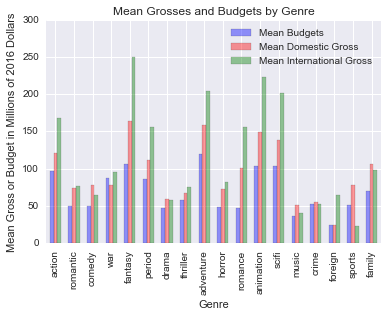

In [23]:
fig, ax = plt.subplots()#figsize = [8,8]

bar_width = 0.20

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(np.arange(len(genres_good)) + bar_width, bygenre['budget_means_mil'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Mean Budgets')

rects2 = plt.bar(np.arange(len(genres_good)) + 2 * bar_width, bygenre['domestic_means_mil'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Mean Domestic Gross')

rects3 = plt.bar(np.arange(len(genres_good)) + 3 * bar_width, bygenre['international_means_mil'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Mean International Gross')

plt.xlabel('Genre')
plt.ylabel('Mean Gross or Budget in Millions of 2016 Dollars')
plt.title('Mean Grosses and Budgets by Genre')
plt.xticks(np.arange(len(genres_good)) + 0.5, bygenre.genre, rotation = 90)
plt.legend(loc = 'best')

In [24]:
xcols = features.columns.tolist()
hitlist2 = ['Domestic Gross (2016 dollars)', 'International Gross (2016 dollars)', 'Opening',
            'Total_Gross/Budget','Domestic_Gross/Budget','International_Gross/Budget', 'total_gross']
for entry in hitlist2:
    while entry in xcols:
        xcols.remove(entry)

In [25]:
X, y = features[xcols], features['Total_Gross/Budget']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
kfold = KFold(len(X_train), n_folds=5, shuffle=True, random_state=42)

In [26]:
def build_grid_search_est(model, X, y, cv=5, **params):
    
    grid_est = GridSearchCV(model, param_grid=params, cv=cv)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.grid_scores_)
    for param in params:
        df[param] = df.parameters.apply(lambda val: val[param])
#         plt.plot(np.log(df.alpha), df.mean_validation_score);
#         plt.semilogx(df.alpha, df.mean_validation_score)
    grid_est.grid_scores_
    return grid_est

In [27]:
lin_reg_est = LinearRegression()
lin_reg_est.fit(X_train, y_train);

//anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [28]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 9, 100))


print(lasso_grid_est.best_params_)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase th

Lasso Grid Search


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase th

{'alpha': 0.0093260334688321997}


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [29]:
ridge_grid_est = build_grid_search_est(Ridge(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 9, 100))

print(ridge_grid_est.best_params_)

{'alpha': 59.94842503189421}


In [30]:
print("Elastic Net Grid Search")
elastic_net_grid_est = build_grid_search_est(ElasticNet(), X_train, y_train, cv=kfold,
                                       alpha=np.logspace(-4, 9, 100))


print(elastic_net_grid_est.best_params_)

Elastic Net Grid Search


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase th

{'alpha': 0.017073526474706922}


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [31]:
# # Tuned the grid search dimensions independently
# # Comment this bit out if you don't want to re-run the time-consuming grid search
# #nestimators 10000
# #samples 10
# #depth 10

# estlist = [int(x) for x in np.logspace(3,4, num = 2)]
# samplist = [int(x) for x in np.logspace(0.5,1.5, num = 3)]
# depthlist = [int(x) for x in np.logspace(3.5,4.5, num = 3)]
# # depthlist.append(None)
# # depthlist

# import time
# t0 = time.time()

# print("Random Forest Grid Search")

# rf_grid_est = build_grid_search_est(rfr(), X_train, y_train, cv=kfold,
#                                        n_estimators=estlist, min_samples_split=samplist, max_depth = depthlist)

# print(rf_grid_est.best_params_)
# print(time.time()-t0)


In [32]:
# best params from above
rf_model = rfr(max_depth = 10, min_samples_split = 10, n_estimators = 10000)
rf_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=10000, n_jobs=1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [33]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred_lr = lin_reg_est.predict(X_test)
print("Linear Regression:", r2_score(y_test, y_pred_lr))

y_pred_la = lasso_grid_est.predict(X_test)
print("Lasso Regression:", r2_score(y_test, y_pred_la))

y_pred_r = ridge_grid_est.predict(X_test)
print("Ridge Regression:", r2_score(y_test, y_pred_r))

y_pred_en = elastic_net_grid_est.predict(X_test)
print("ElasticNet Regression:", r2_score(y_test, y_pred_en))

y_pred_rf = rf_model.predict(X_test)
print("Random Forest:", r2_score(y_test, y_pred_rf))

Linear Regression: 0.0735134732454
Lasso Regression: 0.0771828618648
Ridge Regression: 0.0787526518406
ElasticNet Regression: 0.078145733036
Random Forest: 0.233014287869


In [34]:
def percentile(mylist, percentile):
    mylist2 = mylist[:]
    if type(mylist) != list:
        mylist2 = list(mylist)
    mylist2 = sorted(mylist2)
    num = percentile*(len(mylist2)-1)/100
    lower, upper = mylist2[int(num)], mylist2[int(num) + 1]
    return lower * (int(num) + 1 - num) + upper * (num - int(num))

percentile(np.arange(11)*10,99)

99.0

In [35]:
pct_thresholds = np.arange(5,100,5)
above_thresholds, labels = [], ['All']
for i in pct_thresholds:
    above_thresholds.append(y_test[(y_pred_rf > percentile(y_pred_rf,i))].mean())
    labels.append('Top ' + str(100-i) + '%')

([<matplotlib.axis.XTick at 0x124087400>,
 <a list of 20 Text xticklabel objects>)

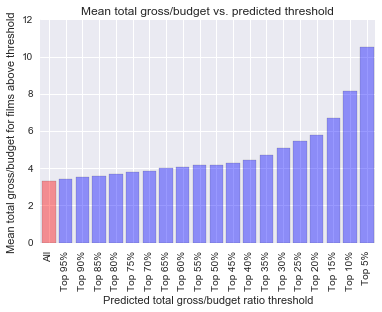

In [36]:
fig, ax = plt.subplots()

bar_width = 0.8
opacity = 0.4;
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(np.arange(len(pct_thresholds)) + 1 + (1-bar_width)/2, above_thresholds, bar_width,
                 alpha=opacity,
                 color='b')

rects2 = plt.bar([(1-bar_width)/2], [y_test.mean()], bar_width,
                 alpha=opacity,
                 color='r')


plt.xlabel('Predicted total gross/budget ratio threshold')
plt.ylabel('Mean total gross/budget for films above threshold')
plt.title('Mean total gross/budget vs. predicted threshold')
plt.xticks(np.arange(len(pct_thresholds) + 1) + 0.5, labels, rotation = 90)